In [13]:
# Setup: imports and paths (DoS-focused version)
import os
import glob
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import torch

pd.set_option('display.max_columns', 120)
sns.set_theme(style='whitegrid')

DATA_DIR = os.path.join(os.getcwd(), 'datasets')
assert os.path.isdir(DATA_DIR), f"Missing datasets dir: {DATA_DIR}"
print('PyTorch:', torch.__version__)
print('Data dir:', DATA_DIR)


PyTorch: 2.8.0+cpu
Data dir: /app/datasets


In [14]:
# Config
LABEL_COL = 'Label'
NROWS_PER_CSV = 200_000   # sample more for V2; adjust as needed
BATCH_SIZE = 512
EPOCHS = 5
LOG_INTERVAL = 50
MAX_BATCHES = None
SEED = 42

import random
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)


In [15]:
# Load CSVs and combine
csv_paths = sorted(glob.glob(os.path.join(DATA_DIR, '*.csv')))
assert csv_paths, 'No CSVs found in datasets/'
print('Found CSVs:', len(csv_paths))

frames = []
for p in csv_paths:
    try:
        df = pd.read_csv(p, nrows=NROWS_PER_CSV)
        df['__source__'] = os.path.basename(p)
        frames.append(df)
        print('Loaded', os.path.basename(p), df.shape)
    except Exception as e:
        print('Skip', os.path.basename(p), e)

data = pd.concat(frames, ignore_index=True)
print('Combined shape:', data.shape)

data.head()


Found CSVs: 8
Loaded Friday-WorkingHours-Afternoon-DDos.pcap_ISCX.csv (200000, 80)
Loaded Friday-WorkingHours-Afternoon-PortScan.pcap_ISCX.csv (200000, 80)
Loaded Friday-WorkingHours-Morning.pcap_ISCX.csv (191033, 80)
Loaded Monday-WorkingHours.pcap_ISCX.csv (200000, 80)
Loaded Thursday-WorkingHours-Afternoon-Infilteration.pcap_ISCX.csv (200000, 80)
Loaded Thursday-WorkingHours-Morning-WebAttacks.pcap_ISCX.csv (170366, 80)
Loaded Tuesday-WorkingHours.pcap_ISCX.csv (200000, 80)
Loaded Wednesday-workingHours.pcap_ISCX.csv (200000, 80)
Combined shape: (1561399, 80)


,Destination Port,Flow Duration,Total Fwd Packets,Total Backward Packets,Total Length of Fwd Packets,Total Length of Bwd Packets,Fwd Packet Length Max,Fwd Packet Length Min,Fwd Packet Length Mean,Fwd Packet Length Std,Bwd Packet Length Max,Bwd Packet Length Min,Bwd Packet Length Mean,Bwd Packet Length Std,Flow Bytes/s,Flow Packets/s,Flow IAT Mean,Flow IAT Std,Flow IAT Max,Flow IAT Min,Fwd IAT Total,Fwd IAT Mean,Fwd IAT Std,Fwd IAT Max,Fwd IAT Min,Bwd IAT Total,Bwd IAT Mean,Bwd IAT Std,Bwd IAT Max,Bwd IAT Min,Fwd PSH Flags,Bwd PSH Flags,Fwd URG Flags,Bwd URG Flags,Fwd Header Length,Bwd Header Length,Fwd Packets/s,Bwd Packets/s,Min Packet Length,Max Packet Length,Packet Length Mean,Packet Length Std,Packet Length Variance,FIN Flag Count,SYN Flag Count,RST Flag Count,PSH Flag Count,ACK Flag Count,URG Flag Count,CWE Flag Count,ECE Flag Count,Down/Up Ratio,Average Packet Size,Avg Fwd Segment Size,Avg Bwd Segment Size,Fwd Header Length.1,Fwd Avg Bytes/Bulk,Fwd Avg Packets/Bulk,Fwd Avg Bulk Rate,Bwd Avg Bytes/Bulk,Bwd Avg Packets/Bulk,Bwd Avg Bulk Rate,Subflow Fwd Packets,Subflow Fwd Bytes,Subflow Bwd Packets,Subflow Bwd Bytes,Init_Win_bytes_forward,Init_Win_bytes_backward,act_data_pkt_fwd,min_seg_size_forward,Active Mean,Active Std,Active Max,Active Min,Idle Mean,Idle Std,Idle Max,Idle Min,Label,__source__
0,54865,3,2,0,12,0,6,6,6.0,0.0,0,0,0.0,0.0,4.000000e+06,666666.66670,3.0,0.0,3,3,3,3.0,0.0,3,3,0,0.0,0.0,0,0,0,0,0,0,40,0,666666.666700,0.000000,6,6,6.0,0.0,0.0,0,0,0,0,1,0,0,0,0,9.0,6.0,0.0,40,0,0,0,0,0,0,2,12,0,0,33,-1,1,20,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN,Friday-WorkingHours-Afternoon-DDos.pcap_ISCX.csv
1,55054,109,1,1,6,6,6,6,6.0,0.0,6,6,6.0,0.0,1.100917e+05,18348.62385,109.0,0.0,109,109,0,0.0,0.0,0,0,0,0.0,0.0,0,0,0,0,0,0,20,20,9174.311927,9174.311927,6,6,6.0,0.0,0.0,0,0,0,0,1,1,0,0,1,9.0,6.0,6.0,20,0,0,0,0,0,0,1,6,1,6,29,256,0,20,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN,Friday-WorkingHours-Afternoon-DDos.pcap_ISCX.csv
2,55055,52,1,1,6,6,6,6,6.0,0.0,6,6,6.0,0.0,2.307692e+05,38461.53846,52.0,0.0,52,52,0,0.0,0.0,0,0,0,0.0,0.0,0,0,0,0,0,0,20,20,19230.769230,19230.769230,6,6,6.0,0.0,0.0,0,0,0,0,1,1,0,0,1,9.0,6.0,6.0,20,0,0,0,0,0,0,1,6,1,6,29,256,0,20,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN,Friday-WorkingHours-Afternoon-DDos.pcap_ISCX.csv
3,46236,34,1,1,6,6,6,6,6.0,0.0,6,6,6.0,0.0,3.529412e+05,58823.52941,34.0,0.0,34,34,0,0.0,0.0,0,0,0,0.0,0.0,0,0,0,0,0,0,20,20,29411.764710,29411.764710,6,6,6.0,0.0,0.0,0,0,0,0,1,1,0,0,1,9.0,6.0,6.0,20,0,0,0,0,0,0,1,6,1,6,31,329,0,20,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN,Friday-WorkingHours-Afternoon-DDos.pcap_ISCX.csv
4,54863,3,2,0,12,0,6,6,6.0,0.0,0,0,0.0,0.0,4.000000e+06,666666.66670,3.0,0.0,3,3,3,3.0,0.0,3,3,0,0.0,0.0,0,0,0,0,0,0,40,0,666666.666700,0.000000,6,6,6.0,0.0,0.0,0,0,0,0,1,0,0,0,0,9.0,6.0,0.0,40,0,0,0,0,0,0,2,12,0,0,32,-1,1,20,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN,Friday-WorkingHours-Afternoon-DDos.pcap_ISCX.csv


In [16]:
# Normalize columns and preview labels
orig_cols = list(data.columns)
data.columns = [str(c).strip() for c in data.columns]
if orig_cols != list(data.columns):
    print('Normalized column names (stripped whitespace).')

assert LABEL_COL in data.columns, f"Label column '{LABEL_COL}' missing in data."
print('Label unique values (sample):', data[LABEL_COL].astype(str).unique()[:20])


Normalized column names (stripped whitespace).
Label unique values (sample): ['BENIGN' 'DDoS' 'PortScan' 'Bot' 'Infiltration'
 'Web Attack � Brute Force' 'Web Attack � XSS'
 'Web Attack � Sql Injection' 'FTP-Patator' 'SSH-Patator' 'DoS slowloris'
 'DoS Slowhttptest' 'DoS Hulk']


In [17]:
# DoS-focused feature list
FEATURES = [
    'Flow Packets/s',
    'Flow Duration',
    'Flow IAT Mean',
    'Idle Mean',
    'Fwd Packets/s',
    'Flow IAT Max',
    'Total Fwd Packets',
    'Packet Length Variance',
    'Init_Win_bytes_forward',
    'SYN Flag Count',
]

# Some datasets use slightly different naming; create a mapping fallback
ALIASES = {
    'Fwd Packets/s': ['Fwd Pkts/s', 'Forward Packets/s'],
    'Flow Packets/s': ['Flow Pkts/s'],
    'Packet Length Variance': ['Pkt Len Var', 'Packet Len Var'],
    'Init_Win_bytes_forward': ['Init_Win_bytes_fwd', 'Init_Win_bytes Fwd', 'Init_Win_bytes forward'],
    'SYN Flag Count': ['SYN Flag Cnt'],
}

resolved_features = []
missing = []
for f in FEATURES:
    if f in data.columns:
        resolved_features.append(f)
    else:
        candidates = ALIASES.get(f, [])
        found = None
        for c in candidates:
            if c in data.columns:
                found = c
                break
        if found is not None:
            print(f"Alias used: '{f}' -> '{found}'")
            resolved_features.append(found)
        else:
            missing.append(f)

print('Resolved features:', resolved_features)
if missing:
    print('Missing features (not found in data):', missing)

X_df = data[resolved_features].copy()


Resolved features: ['Flow Packets/s', 'Flow Duration', 'Flow IAT Mean', 'Idle Mean', 'Fwd Packets/s', 'Flow IAT Max', 'Total Fwd Packets', 'Packet Length Variance', 'Init_Win_bytes_forward', 'SYN Flag Count']


In [18]:
# Clean NaNs/Infs and scale
X_df = X_df.replace([np.inf, -np.inf], np.nan)
na_ratio = X_df.isna().mean().sort_values(ascending=False)
print('NaN ratio (top):')
print(na_ratio.head(10))

X_df = X_df.fillna(0.0).astype(np.float32)

# Standard scaling (z-score)
X_mean = X_df.mean()
X_std = X_df.std().replace(0, 1)
X = ((X_df - X_mean) / X_std).astype(np.float32)

# Labels
y_cat = data[LABEL_COL].astype('category')
class_names = list(y_cat.cat.categories)
y = y_cat.cat.codes.values.astype(np.int64)
num_classes = len(class_names)
print('X shape:', X.shape, '| classes:', num_classes)
print('Classes:', class_names[:20])


NaN ratio (top):
Flow Packets/s            0.000956
Flow Duration             0.000000
Flow IAT Mean             0.000000
Idle Mean                 0.000000
Fwd Packets/s             0.000000
Flow IAT Max              0.000000
Total Fwd Packets         0.000000
Packet Length Variance    0.000000
Init_Win_bytes_forward    0.000000
SYN Flag Count            0.000000
dtype: float64
X shape: (1561399, 10) | classes: 13
Classes: ['BENIGN', 'Bot', 'DDoS', 'DoS Hulk', 'DoS Slowhttptest', 'DoS slowloris', 'FTP-Patator', 'Infiltration', 'PortScan', 'SSH-Patator', 'Web Attack � Brute Force', 'Web Attack � Sql Injection', 'Web Attack � XSS']


In [19]:
# Stratified 60/20/20 split using sklearn
from sklearn.model_selection import train_test_split

# First split: Train vs temp (train=60%, temp=40%)
X_temp, X_test, y_temp, y_test = train_test_split(
    X.values, y, test_size=0.20, random_state=SEED, stratify=y
)
# Now split remaining into train and val (train: 60% of total, val: 20% of total)
X_train, X_val, y_train, y_val = train_test_split(
    X_temp, y_temp, test_size=0.25, random_state=SEED, stratify=y_temp
)

print('Shapes:', X_train.shape, X_val.shape, X_test.shape)


Shapes: (936839, 10) (312280, 10) (312280, 10)


In [20]:
# Torch datasets and loaders
import torch
from torch.utils.data import TensorDataset, DataLoader
import torch.nn as nn
import torch.optim as optim

X_train_t = torch.from_numpy(X_train).float()
X_val_t = torch.from_numpy(X_val).float()
X_test_t = torch.from_numpy(X_test).float()
y_train_t = torch.from_numpy(y_train)
y_val_t = torch.from_numpy(y_val)
y_test_t = torch.from_numpy(y_test)

train_ds = TensorDataset(X_train_t, y_train_t)
val_ds = TensorDataset(X_val_t, y_val_t)
test_ds = TensorDataset(X_test_t, y_test_t)

train_dl = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True)
val_dl = DataLoader(val_ds, batch_size=BATCH_SIZE)
test_dl = DataLoader(test_ds, batch_size=BATCH_SIZE)

class MLP(nn.Module):
    def __init__(self, in_dim: int, out_dim: int):
        super().__init__()
        hidden = max(32, min(512, in_dim * 2))
        self.net = nn.Sequential(
            nn.Linear(in_dim, hidden),
            nn.ReLU(),
            nn.BatchNorm1d(hidden),
            nn.Linear(hidden, hidden),
            nn.ReLU(),
            nn.BatchNorm1d(hidden),
            nn.Linear(hidden, out_dim),
        )
    def forward(self, x):
        return self.net(x)

in_dim = X_train.shape[1]
model = MLP(in_dim, num_classes)

if torch.cuda.is_available():
    device = torch.device('cuda')
elif hasattr(torch.backends, 'mps') and torch.backends.mps.is_available():
    device = torch.device('mps')
else:
    device = torch.device('cpu')
print('Using device:', device)
model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)


Using device: cpu


In [21]:
# Training
try:
    from tqdm import tqdm
except Exception:
    def tqdm(x, **kwargs):
        return x


def accuracy(logits, targets):
    preds = logits.argmax(dim=1)
    return (preds == targets).float().mean().item()

history = {'train_loss': [], 'val_loss': [], 'train_acc': [], 'val_acc': []}

for epoch in range(1, EPOCHS + 1):
    model.train()
    train_loss = 0.0
    train_acc = 0.0
    num_train = 0
    for b_idx, (xb, yb) in enumerate(tqdm(train_dl, leave=False)):
        if MAX_BATCHES and b_idx >= MAX_BATCHES:
            break
        xb = xb.to(device)
        yb = yb.to(device)
        optimizer.zero_grad()
        out = model(xb)
        loss = criterion(out, yb.long())
        loss.backward()
        optimizer.step()
        train_loss += loss.item() * xb.size(0)
        train_acc += accuracy(out, yb) * xb.size(0)
        num_train += xb.size(0)
        if (b_idx + 1) % LOG_INTERVAL == 0:
            print(f'Epoch {epoch} | Batch {b_idx+1} | loss={loss.item():.4f}')

    train_loss /= max(1, num_train)
    train_acc /= max(1, num_train)

    model.eval()
    val_loss = 0.0
    val_acc = 0.0
    num_val = 0
    with torch.no_grad():
        for xb, yb in val_dl:
            xb = xb.to(device)
            yb = yb.to(device)
            out = model(xb)
            loss = criterion(out, yb.long())
            val_loss += loss.item() * xb.size(0)
            val_acc += accuracy(out, yb) * xb.size(0)
            num_val += xb.size(0)
    val_loss /= max(1, num_val)
    val_acc /= max(1, num_val)

    history['train_loss'].append(train_loss)
    history['val_loss'].append(val_loss)
    history['train_acc'].append(train_acc)
    history['val_acc'].append(val_acc)

    print(f'Epoch {epoch}: train_loss={train_loss:.4f} val_loss={val_loss:.4f} train_acc={train_acc:.4f} val_acc={val_acc:.4f}')


  0%|          | 0/1830 [00:00<?, ?it/s]

  3%|▎         | 58/1830 [00:00<00:15, 116.55it/s]

Epoch 1 | Batch 50 | loss=1.7014


  7%|▋         | 120/1830 [00:01<00:11, 143.50it/s]

Epoch 1 | Batch 100 | loss=1.0168


  9%|▉         | 167/1830 [00:01<00:14, 117.66it/s]

Epoch 1 | Batch 150 | loss=0.7191


 12%|█▏        | 214/1830 [00:02<00:16, 97.66it/s] 

Epoch 1 | Batch 200 | loss=0.5623


 15%|█▍        | 271/1830 [00:02<00:14, 107.28it/s]

Epoch 1 | Batch 250 | loss=0.4167


 18%|█▊        | 332/1830 [00:03<00:10, 143.23it/s]

Epoch 1 | Batch 300 | loss=0.3686


 19%|█▉        | 350/1830 [00:03<00:09, 153.09it/s]

Epoch 1 | Batch 350 | loss=0.2847


 23%|██▎       | 426/1830 [00:03<00:10, 133.98it/s]

Epoch 1 | Batch 400 | loss=0.3069


 26%|██▌       | 476/1830 [00:04<00:08, 150.69it/s]

Epoch 1 | Batch 450 | loss=0.3055


 28%|██▊       | 514/1830 [00:04<00:07, 164.88it/s]

Epoch 1 | Batch 500 | loss=0.3387


 31%|███▏      | 573/1830 [00:04<00:07, 163.09it/s]

Epoch 1 | Batch 550 | loss=0.3110


 34%|███▍      | 628/1830 [00:05<00:07, 160.78it/s]

Epoch 1 | Batch 600 | loss=0.2561


 37%|███▋      | 678/1830 [00:05<00:07, 147.77it/s]

Epoch 1 | Batch 650 | loss=0.1945


 40%|███▉      | 731/1830 [00:05<00:06, 163.82it/s]

Epoch 1 | Batch 700 | loss=0.2734


 43%|████▎     | 787/1830 [00:06<00:05, 176.20it/s]

Epoch 1 | Batch 750 | loss=0.2256


 45%|████▍     | 823/1830 [00:06<00:06, 165.69it/s]

Epoch 1 | Batch 800 | loss=0.2825


 48%|████▊     | 873/1830 [00:06<00:07, 131.63it/s]

Epoch 1 | Batch 850 | loss=0.2431


 50%|█████     | 920/1830 [00:07<00:06, 143.13it/s]

Epoch 1 | Batch 900 | loss=0.2879


 53%|█████▎    | 970/1830 [00:07<00:05, 156.48it/s]

Epoch 1 | Batch 950 | loss=0.2232


 56%|█████▌    | 1023/1830 [00:07<00:05, 161.19it/s]

Epoch 1 | Batch 1000 | loss=0.2036


 59%|█████▊    | 1075/1830 [00:08<00:04, 167.49it/s]

Epoch 1 | Batch 1050 | loss=0.1912


 62%|██████▏   | 1126/1830 [00:08<00:04, 158.02it/s]

Epoch 1 | Batch 1100 | loss=0.2790


 64%|██████▍   | 1180/1830 [00:08<00:03, 169.63it/s]

Epoch 1 | Batch 1150 | loss=0.2055


 66%|██████▋   | 1214/1830 [00:08<00:03, 154.18it/s]

Epoch 1 | Batch 1200 | loss=0.1952


 70%|███████   | 1281/1830 [00:09<00:03, 147.11it/s]

Epoch 1 | Batch 1250 | loss=0.2291


 73%|███████▎  | 1335/1830 [00:09<00:03, 162.14it/s]

Epoch 1 | Batch 1300 | loss=0.2151


 75%|███████▌  | 1373/1830 [00:09<00:02, 163.18it/s]

Epoch 1 | Batch 1350 | loss=0.1873


 78%|███████▊  | 1427/1830 [00:10<00:02, 170.51it/s]

Epoch 1 | Batch 1400 | loss=0.1895


 81%|████████  | 1482/1830 [00:10<00:02, 173.61it/s]

Epoch 1 | Batch 1450 | loss=0.2210


 83%|████████▎ | 1519/1830 [00:10<00:01, 159.11it/s]

Epoch 1 | Batch 1500 | loss=0.2392


 86%|████████▌ | 1570/1830 [00:11<00:01, 161.72it/s]

Epoch 1 | Batch 1550 | loss=0.2190


 89%|████████▉ | 1625/1830 [00:11<00:01, 161.51it/s]

Epoch 1 | Batch 1600 | loss=0.1962


 92%|█████████▏| 1677/1830 [00:11<00:00, 161.97it/s]

Epoch 1 | Batch 1650 | loss=0.2209


 94%|█████████▎| 1714/1830 [00:12<00:00, 164.63it/s]

Epoch 1 | Batch 1700 | loss=0.1399


 96%|█████████▋| 1763/1830 [00:12<00:00, 138.17it/s]

Epoch 1 | Batch 1750 | loss=0.1848


 99%|█████████▊| 1807/1830 [00:12<00:00, 108.68it/s]

Epoch 1 | Batch 1800 | loss=0.1564


Epoch 1: train_loss=0.3647 val_loss=0.2307 train_acc=0.9034 val_acc=0.9214


  4%|▍         | 73/1830 [00:00<00:14, 125.23it/s]

Epoch 2 | Batch 50 | loss=0.1871


  7%|▋         | 128/1830 [00:00<00:08, 201.23it/s]

Epoch 2 | Batch 100 | loss=0.1786


 10%|▉         | 178/1830 [00:00<00:07, 225.98it/s]

Epoch 2 | Batch 150 | loss=0.2357
Epoch 2 | Batch 200 | loss=0.1416


 15%|█▌        | 276/1830 [00:01<00:06, 233.90it/s]

Epoch 2 | Batch 250 | loss=0.1813


 18%|█▊        | 329/1830 [00:01<00:06, 248.16it/s]

Epoch 2 | Batch 300 | loss=0.1805


 21%|██        | 379/1830 [00:01<00:06, 218.65it/s]

Epoch 2 | Batch 350 | loss=0.1787


 23%|██▎       | 425/1830 [00:02<00:07, 180.70it/s]

Epoch 2 | Batch 400 | loss=0.2073


 27%|██▋       | 496/1830 [00:02<00:06, 208.52it/s]

Epoch 2 | Batch 450 | loss=0.1689


 30%|███       | 552/1830 [00:02<00:05, 239.22it/s]

Epoch 2 | Batch 500 | loss=0.2569
Epoch 2 | Batch 550 | loss=0.1725


 34%|███▍      | 628/1830 [00:02<00:04, 241.33it/s]

Epoch 2 | Batch 600 | loss=0.1834


 37%|███▋      | 678/1830 [00:03<00:05, 214.19it/s]

Epoch 2 | Batch 650 | loss=0.1761


 40%|███▉      | 727/1830 [00:03<00:04, 225.35it/s]

Epoch 2 | Batch 700 | loss=0.2277
Epoch 2 | Batch 750 | loss=0.1665


 45%|████▌     | 829/1830 [00:03<00:04, 242.43it/s]

Epoch 2 | Batch 800 | loss=0.2269


 48%|████▊     | 879/1830 [00:04<00:04, 234.30it/s]

Epoch 2 | Batch 850 | loss=0.2182


 51%|█████     | 927/1830 [00:04<00:04, 192.84it/s]

Epoch 2 | Batch 900 | loss=0.2680


 53%|█████▎    | 973/1830 [00:04<00:04, 207.87it/s]

Epoch 2 | Batch 950 | loss=0.2130


 57%|█████▋    | 1044/1830 [00:04<00:03, 222.91it/s]

Epoch 2 | Batch 1000 | loss=0.1916


 58%|█████▊    | 1067/1830 [00:05<00:03, 223.27it/s]

Epoch 2 | Batch 1050 | loss=0.1724


 62%|██████▏   | 1139/1830 [00:05<00:03, 197.55it/s]

Epoch 2 | Batch 1100 | loss=0.1539


 65%|██████▍   | 1189/1830 [00:05<00:02, 215.31it/s]

Epoch 2 | Batch 1150 | loss=0.1716


 68%|██████▊   | 1237/1830 [00:05<00:02, 219.16it/s]

Epoch 2 | Batch 1200 | loss=0.1784


 70%|███████   | 1286/1830 [00:06<00:02, 221.54it/s]

Epoch 2 | Batch 1250 | loss=0.1623


 73%|███████▎  | 1335/1830 [00:06<00:02, 214.85it/s]

Epoch 2 | Batch 1300 | loss=0.1789


 74%|███████▍  | 1357/1830 [00:06<00:02, 208.00it/s]

Epoch 2 | Batch 1350 | loss=0.2420


 78%|███████▊  | 1424/1830 [00:06<00:02, 172.14it/s]

Epoch 2 | Batch 1400 | loss=0.2270


 81%|████████  | 1474/1830 [00:07<00:01, 202.35it/s]

Epoch 2 | Batch 1450 | loss=0.1801


 83%|████████▎ | 1516/1830 [00:07<00:01, 183.06it/s]

Epoch 2 | Batch 1500 | loss=0.2409


 86%|████████▌ | 1573/1830 [00:07<00:01, 176.14it/s]

Epoch 2 | Batch 1550 | loss=0.2005


 89%|████████▉ | 1637/1830 [00:07<00:00, 196.95it/s]

Epoch 2 | Batch 1600 | loss=0.1836


 92%|█████████▏| 1686/1830 [00:08<00:00, 221.10it/s]

Epoch 2 | Batch 1650 | loss=0.1440


 95%|█████████▍| 1732/1830 [00:08<00:00, 221.07it/s]

Epoch 2 | Batch 1700 | loss=0.1580


 97%|█████████▋| 1778/1830 [00:08<00:00, 217.83it/s]

Epoch 2 | Batch 1750 | loss=0.1508


Epoch 2 | Batch 1800 | loss=0.1509


Epoch 2: train_loss=0.1903 val_loss=0.1851 train_acc=0.9331 val_acc=0.9322


  5%|▌         | 93/1830 [00:00<00:07, 239.07it/s]

Epoch 3 | Batch 50 | loss=0.2112


  8%|▊         | 140/1830 [00:00<00:07, 225.41it/s]

Epoch 3 | Batch 100 | loss=0.1408


  9%|▉         | 163/1830 [00:00<00:10, 158.85it/s]

Epoch 3 | Batch 150 | loss=0.1433


 13%|█▎        | 234/1830 [00:01<00:09, 172.57it/s]

Epoch 3 | Batch 200 | loss=0.1671


 15%|█▌        | 280/1830 [00:01<00:08, 184.71it/s]

Epoch 3 | Batch 250 | loss=0.1731


 18%|█▊        | 330/1830 [00:01<00:06, 214.80it/s]

Epoch 3 | Batch 300 | loss=0.1817


 21%|██        | 380/1830 [00:01<00:06, 230.74it/s]

Epoch 3 | Batch 350 | loss=0.2348
Epoch 3 | Batch 400 | loss=0.1745


 26%|██▌       | 477/1830 [00:02<00:05, 229.86it/s]

Epoch 3 | Batch 450 | loss=0.1868


 29%|██▉       | 528/1830 [00:02<00:05, 235.31it/s]

Epoch 3 | Batch 500 | loss=0.1356
Epoch 3 | Batch 550 | loss=0.1384


 34%|███▍      | 629/1830 [00:02<00:04, 241.29it/s]

Epoch 3 | Batch 600 | loss=0.1402
Epoch 3 | Batch 650 | loss=0.2076


 39%|███▊      | 706/1830 [00:03<00:04, 227.23it/s]

Epoch 3 | Batch 700 | loss=0.1978


 43%|████▎     | 782/1830 [00:03<00:04, 220.95it/s]

Epoch 3 | Batch 750 | loss=0.1834


 45%|████▌     | 831/1830 [00:04<00:05, 192.50it/s]

Epoch 3 | Batch 800 | loss=0.1585


 48%|████▊     | 882/1830 [00:04<00:04, 219.91it/s]

Epoch 3 | Batch 850 | loss=0.1608
Epoch 3 | Batch 900 | loss=0.1844


 54%|█████▎    | 983/1830 [00:04<00:03, 237.14it/s]

Epoch 3 | Batch 950 | loss=0.1761
Epoch 3 | Batch 1000 | loss=0.1333


 59%|█████▉    | 1087/1830 [00:05<00:03, 247.21it/s]

Epoch 3 | Batch 1050 | loss=0.1943
Epoch 3 | Batch 1100 | loss=0.1290


 65%|██████▍   | 1185/1830 [00:05<00:03, 196.76it/s]

Epoch 3 | Batch 1150 | loss=0.1391
Epoch 3 | Batch 1200 | loss=0.1175


 71%|███████   | 1292/1830 [00:05<00:02, 242.01it/s]

Epoch 3 | Batch 1250 | loss=0.1476
Epoch 3 | Batch 1300 | loss=0.1488


 77%|███████▋  | 1401/1830 [00:06<00:01, 259.45it/s]

Epoch 3 | Batch 1350 | loss=0.1690
Epoch 3 | Batch 1400 | loss=0.1619


 81%|████████  | 1480/1830 [00:06<00:01, 207.12it/s]

Epoch 3 | Batch 1450 | loss=0.1474


 84%|████████▎ | 1530/1830 [00:07<00:01, 226.05it/s]

Epoch 3 | Batch 1500 | loss=0.1645


 86%|████████▌ | 1578/1830 [00:07<00:01, 219.21it/s]

Epoch 3 | Batch 1550 | loss=0.1559


 89%|████████▉ | 1628/1830 [00:07<00:00, 230.25it/s]

Epoch 3 | Batch 1600 | loss=0.1273


 91%|█████████▏| 1673/1830 [00:07<00:00, 186.67it/s]

Epoch 3 | Batch 1650 | loss=0.1799


 94%|█████████▍| 1724/1830 [00:07<00:00, 215.33it/s]

Epoch 3 | Batch 1700 | loss=0.1864


 98%|█████████▊| 1800/1830 [00:08<00:00, 232.14it/s]

Epoch 3 | Batch 1750 | loss=0.1620
Epoch 3 | Batch 1800 | loss=0.1302


Epoch 3: train_loss=0.1667 val_loss=0.1391 train_acc=0.9416 val_acc=0.9534


  4%|▍         | 74/1830 [00:00<00:08, 214.77it/s]

Epoch 4 | Batch 50 | loss=0.1271


  8%|▊         | 143/1830 [00:00<00:08, 191.86it/s]

Epoch 4 | Batch 100 | loss=0.1747


 10%|█         | 188/1830 [00:00<00:08, 203.46it/s]

Epoch 4 | Batch 150 | loss=0.1585


 13%|█▎        | 236/1830 [00:01<00:07, 219.30it/s]

Epoch 4 | Batch 200 | loss=0.1145
Epoch 4 | Batch 250 | loss=0.1274


 18%|█▊        | 334/1830 [00:01<00:06, 230.37it/s]

Epoch 4 | Batch 300 | loss=0.1383


 21%|██        | 379/1830 [00:01<00:07, 201.65it/s]

Epoch 4 | Batch 350 | loss=0.1027


 23%|██▎       | 424/1830 [00:02<00:06, 206.26it/s]

Epoch 4 | Batch 400 | loss=0.1575


 27%|██▋       | 498/1830 [00:02<00:05, 230.28it/s]

Epoch 4 | Batch 450 | loss=0.1165


 30%|███       | 551/1830 [00:02<00:05, 245.88it/s]

Epoch 4 | Batch 500 | loss=0.1220
Epoch 4 | Batch 550 | loss=0.1478


 34%|███▍      | 629/1830 [00:02<00:04, 244.12it/s]

Epoch 4 | Batch 600 | loss=0.1038


 37%|███▋      | 680/1830 [00:03<00:04, 243.15it/s]

Epoch 4 | Batch 650 | loss=0.1614
Epoch 4 | Batch 700 | loss=0.1440


 43%|████▎     | 787/1830 [00:03<00:04, 257.35it/s]

Epoch 4 | Batch 750 | loss=0.1625
Epoch 4 | Batch 800 | loss=0.1330


 47%|████▋     | 865/1830 [00:03<00:03, 251.24it/s]

Epoch 4 | Batch 850 | loss=0.1372


 51%|█████     | 933/1830 [00:04<00:04, 180.96it/s]

Epoch 4 | Batch 900 | loss=0.1150


 53%|█████▎    | 978/1830 [00:04<00:04, 184.91it/s]

Epoch 4 | Batch 950 | loss=0.1947


 56%|█████▌    | 1029/1830 [00:04<00:03, 214.54it/s]

Epoch 4 | Batch 1000 | loss=0.1389


 59%|█████▉    | 1077/1830 [00:05<00:04, 181.95it/s]

Epoch 4 | Batch 1050 | loss=0.1057


 63%|██████▎   | 1156/1830 [00:05<00:03, 201.98it/s]

Epoch 4 | Batch 1100 | loss=0.0734
Epoch 4 | Batch 1150 | loss=0.1601


 67%|██████▋   | 1230/1830 [00:05<00:02, 206.78it/s]

Epoch 4 | Batch 1200 | loss=0.1250


 70%|██████▉   | 1276/1830 [00:05<00:02, 216.17it/s]

Epoch 4 | Batch 1250 | loss=0.1842


 73%|███████▎  | 1328/1830 [00:06<00:02, 235.80it/s]

Epoch 4 | Batch 1300 | loss=0.1264


 75%|███████▌  | 1376/1830 [00:06<00:02, 209.75it/s]

Epoch 4 | Batch 1350 | loss=0.1132


 79%|███████▉  | 1447/1830 [00:06<00:01, 203.50it/s]

Epoch 4 | Batch 1400 | loss=0.0807


 80%|████████  | 1468/1830 [00:06<00:01, 191.13it/s]

Epoch 4 | Batch 1450 | loss=0.1160


 83%|████████▎ | 1527/1830 [00:07<00:01, 175.07it/s]

Epoch 4 | Batch 1500 | loss=0.1718


 87%|████████▋ | 1598/1830 [00:07<00:01, 201.74it/s]

Epoch 4 | Batch 1550 | loss=0.1037
Epoch 4 | Batch 1600 | loss=0.1323


 93%|█████████▎| 1695/1830 [00:08<00:00, 233.36it/s]

Epoch 4 | Batch 1650 | loss=0.1318


 95%|█████████▌| 1744/1830 [00:08<00:00, 236.59it/s]

Epoch 4 | Batch 1700 | loss=0.1140
Epoch 4 | Batch 1750 | loss=0.1298


Epoch 4 | Batch 1800 | loss=0.1285
Epoch 4: train_loss=0.1398 val_loss=0.1256 train_acc=0.9544 val_acc=0.9574


  5%|▌         | 93/1830 [00:00<00:09, 192.74it/s]

Epoch 5 | Batch 50 | loss=0.0905


  8%|▊         | 144/1830 [00:00<00:07, 212.18it/s]

Epoch 5 | Batch 100 | loss=0.1537


 10%|█         | 191/1830 [00:00<00:07, 220.33it/s]

Epoch 5 | Batch 150 | loss=0.1230


 13%|█▎        | 238/1830 [00:01<00:07, 219.45it/s]

Epoch 5 | Batch 200 | loss=0.1360


 16%|█▌        | 290/1830 [00:01<00:07, 207.15it/s]

Epoch 5 | Batch 250 | loss=0.1481
Epoch 5 | Batch 300 | loss=0.1077


 21%|██▏       | 392/1830 [00:01<00:06, 238.92it/s]

Epoch 5 | Batch 350 | loss=0.1115
Epoch 5 | Batch 400 | loss=0.1336


 27%|██▋       | 495/1830 [00:02<00:05, 240.47it/s]

Epoch 5 | Batch 450 | loss=0.0953
Epoch 5 | Batch 500 | loss=0.1469


 31%|███▏      | 575/1830 [00:02<00:05, 247.04it/s]

Epoch 5 | Batch 550 | loss=0.1218
Epoch 5 | Batch 600 | loss=0.1213


 37%|███▋      | 675/1830 [00:03<00:05, 224.79it/s]

Epoch 5 | Batch 650 | loss=0.1147


 41%|████      | 754/1830 [00:03<00:04, 249.67it/s]

Epoch 5 | Batch 700 | loss=0.0905
Epoch 5 | Batch 750 | loss=0.1095


 45%|████▌     | 831/1830 [00:03<00:04, 246.96it/s]

Epoch 5 | Batch 800 | loss=0.1481


 48%|████▊     | 882/1830 [00:03<00:04, 199.84it/s]

Epoch 5 | Batch 850 | loss=0.1314


 51%|█████     | 932/1830 [00:04<00:04, 221.67it/s]

Epoch 5 | Batch 900 | loss=0.0905
Epoch 5 | Batch 950 | loss=0.1066


 56%|█████▋    | 1031/1830 [00:04<00:04, 197.93it/s]

Epoch 5 | Batch 1000 | loss=0.1789


 59%|█████▉    | 1076/1830 [00:04<00:03, 209.16it/s]

Epoch 5 | Batch 1050 | loss=0.1035


 61%|██████▏   | 1125/1830 [00:05<00:03, 224.60it/s]

Epoch 5 | Batch 1100 | loss=0.1146


 64%|██████▍   | 1177/1830 [00:05<00:02, 241.37it/s]

Epoch 5 | Batch 1150 | loss=0.1206


 67%|██████▋   | 1231/1830 [00:05<00:02, 224.88it/s]

Epoch 5 | Batch 1200 | loss=0.1016
Epoch 5 | Batch 1250 | loss=0.1203


 73%|███████▎  | 1333/1830 [00:06<00:02, 243.03it/s]

Epoch 5 | Batch 1300 | loss=0.1153


 76%|███████▌  | 1385/1830 [00:06<00:01, 245.57it/s]

Epoch 5 | Batch 1350 | loss=0.1287


 78%|███████▊  | 1435/1830 [00:06<00:01, 244.93it/s]

Epoch 5 | Batch 1400 | loss=0.1038
Epoch 5 | Batch 1450 | loss=0.1170


 84%|████████▍ | 1537/1830 [00:06<00:01, 225.40it/s]

Epoch 5 | Batch 1500 | loss=0.1119


 87%|████████▋ | 1586/1830 [00:07<00:01, 213.83it/s]

Epoch 5 | Batch 1550 | loss=0.0960


 90%|████████▉ | 1639/1830 [00:07<00:00, 235.12it/s]

Epoch 5 | Batch 1600 | loss=0.1171
Epoch 5 | Batch 1650 | loss=0.1098


 94%|█████████▍| 1716/1830 [00:07<00:00, 246.76it/s]

Epoch 5 | Batch 1700 | loss=0.1384


 98%|█████████▊| 1786/1830 [00:08<00:00, 208.79it/s]

Epoch 5 | Batch 1750 | loss=0.0922


Epoch 5 | Batch 1800 | loss=0.1076


Epoch 5: train_loss=0.1217 val_loss=0.1287 train_acc=0.9625 val_acc=0.9686


Test: loss=0.1278 acc=0.9692
Classification report:
                            precision    recall  f1-score   support

                    BENIGN       0.98      0.98      0.98    235953
                       Bot       0.00      0.00      0.00       393
                      DDoS       0.98      0.97      0.97     25606
                  DoS Hulk       0.93      0.90      0.91     23735
          DoS Slowhttptest       0.86      0.89      0.87      1100
             DoS slowloris       0.94      0.80      0.87      1159
               FTP-Patator       0.99      0.50      0.66      1588
              Infiltration       0.00      0.00      0.00         6
                  PortScan       0.93      0.98      0.95     21870
               SSH-Patator       1.00      0.49      0.66       434
  Web Attack � Brute Force       0.00      0.00      0.00       302
Web Attack � Sql Injection       0.00      0.00      0.00         4
          Web Attack � XSS       0.00      0.00      0.00      

/usr/local/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


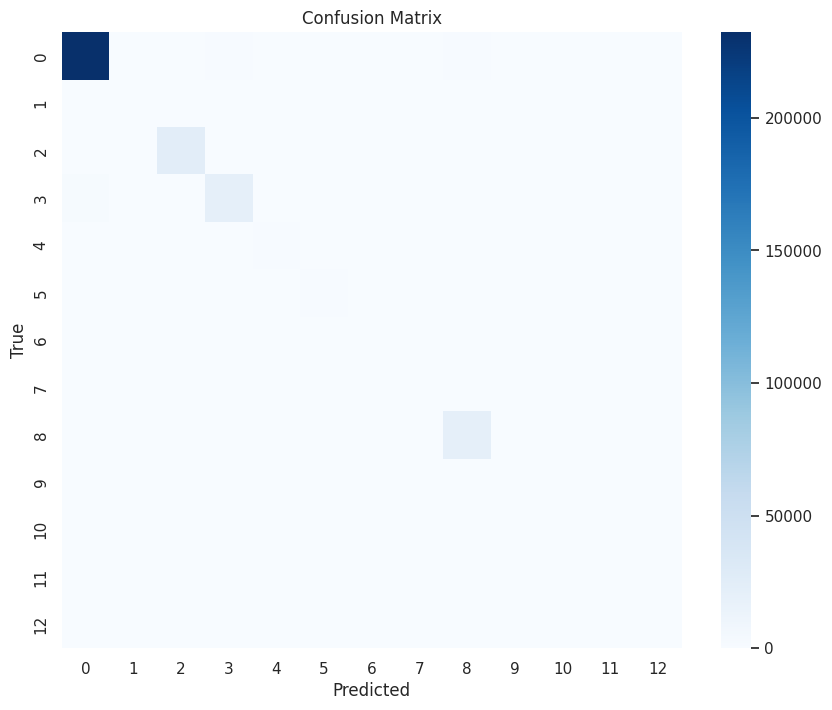

In [22]:
# Test evaluation
model.eval()
from math import isnan

test_loss = 0.0
test_acc = 0.0
num_test = 0
with torch.no_grad():
    for xb, yb in test_dl:
        xb = xb.to(device)
        yb = yb.to(device)
        out = model(xb)
        loss = criterion(out, yb.long())
        test_loss += loss.item() * xb.size(0)
        test_acc += ((out.argmax(dim=1) == yb).float().mean().item()) * xb.size(0)
        num_test += xb.size(0)

test_loss /= max(1, num_test)
# average of per-batch accuracies weighted by batch size
correct = 0
count = 0
with torch.no_grad():
    for xb, yb in test_dl:
        xb = xb.to(device)
        yb = yb.to(device)
        out = model(xb)
        preds = out.argmax(dim=1)
        correct += (preds == yb).sum().item()
        count += xb.size(0)

test_acc = correct / max(1, count)
print(f'Test: loss={test_loss:.4f} acc={test_acc:.4f}')

# Confusion matrix
from sklearn.metrics import confusion_matrix, classification_report

all_preds = []
all_true = []
with torch.no_grad():
    for xb, yb in test_dl:
        xb = xb.to(device)
        out = model(xb)
        all_preds.extend(out.argmax(dim=1).cpu().numpy())
        all_true.extend(yb.cpu().numpy())

cm = confusion_matrix(all_true, all_preds)
print('Classification report:')
print(classification_report(all_true, all_preds, target_names=class_names))

import seaborn as sns
plt.figure(figsize=(10,8))
sns.heatmap(cm, annot=False, cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()


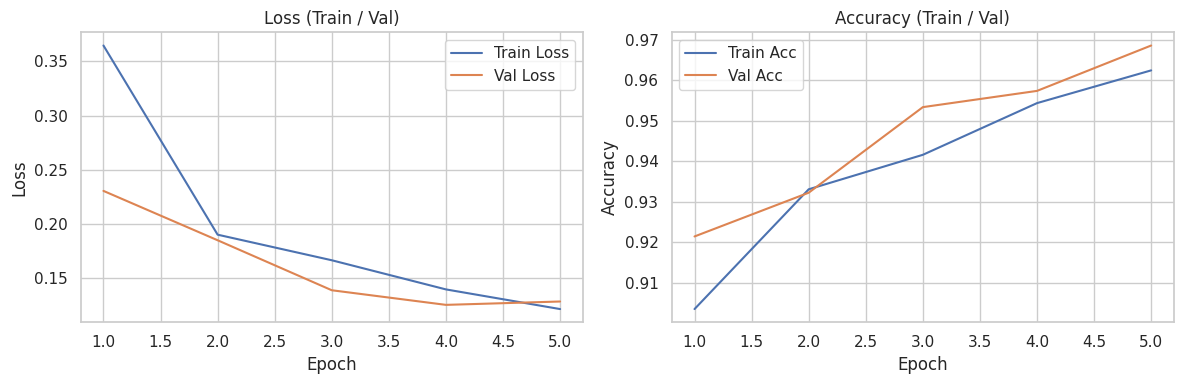

In [23]:
# Curves
fig, axes = plt.subplots(1, 2, figsize=(12,4))
x_epochs = list(range(1, len(history['train_loss']) + 1))
axes[0].plot(x_epochs, history['train_loss'], label='Train Loss')
axes[0].plot(x_epochs, history['val_loss'], label='Val Loss')
axes[0].set_title('Loss (Train / Val)')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Loss')
axes[0].legend(loc='best')
axes[1].plot(x_epochs, history['train_acc'], label='Train Acc')
axes[1].plot(x_epochs, history['val_acc'], label='Val Acc')
axes[1].set_title('Accuracy (Train / Val)')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Accuracy')
axes[1].legend(loc='best')
plt.tight_layout()
plt.show()


### Notes
- This `modelV2.ipynb` focuses on DoS-relevant features only:
  - Flow Packets/s, Flow Duration, Flow IAT Mean, Idle Mean, Fwd Packets/s,
    Flow IAT Max, Total Fwd Packets, Packet Length Variance,
    Init_Win_bytes_forward, SYN Flag Count.
- Uses stratified 60/20/20 split (train/val/test) and a compact MLP.
- Adjust `NROWS_PER_CSV`, `EPOCHS`, and model width as needed for runtime/performance.
- If any feature columns are missing under slightly different names, the alias map will attempt to resolve them.


In [24]:
# Save artifacts (optional)
ARTIFACTS_DIR = os.path.join(os.getcwd(), 'artifacts')
os.makedirs(ARTIFACTS_DIR, exist_ok=True)

# Save model
model_path = os.path.join(ARTIFACTS_DIR, 'dos_mlp.pt')
torch.save(model.state_dict(), model_path)
print('Saved model to:', model_path)

# Save scaler stats for reproducible preprocessing
scaler_path = os.path.join(ARTIFACTS_DIR, 'scaler_stats.npz')
np.savez(scaler_path, mean=X_mean.values, std=X_std.values, columns=np.array(X_df.columns))
print('Saved scaler to:', scaler_path)

# Save class mapping
classes_path = os.path.join(ARTIFACTS_DIR, 'classes.txt')
with open(classes_path, 'w') as f:
    for cname in class_names:
        f.write(str(cname) + '\n')
print('Saved classes to:', classes_path)


Saved model to: /app/artifacts/dos_mlp.pt
Saved scaler to: /app/artifacts/scaler_stats.npz
Saved classes to: /app/artifacts/classes.txt
